# Hiring Classification



In [ ]:
# As per my interpretation, the 'note' column doesn't cap at 100; it can exceed 100, given that we have over a thousand such values.

In [154]:
import re
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, recall_score, roc_curve, roc_auc_score, classification_report
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold

## Importing Dataset

In [155]:
df = pd.read_csv(r'data.csv').drop(columns = ['Unnamed: 0', 'index'])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by = 'date')
print(f'Period of data ranges from {df.date.min()} to {df.date.max()}, so the total data is for around {round((df.date.max() - df.date.min()).days/365, 2)} years')

Period of data ranges from 2010-01-01 00:00:00 to 2014-12-31 00:00:00, so the total data is for around 5.0 years


In [156]:
# length of the dataset

total_len = len(df)

### High Level Inspection

In [157]:
display(df.head())
display(df.tail())

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
3335,2010-01-01,brun,34.0,14.0,36232.0,M,licence,geologie,65.43,non,0
11185,2010-01-01,brun,40.0,9.0,44539.0,F,licence,archeologie,70.46,oui,1
4645,2010-01-01,brun,25.0,13.0,46881.0,M,bac,geologie,29.52,non,0
19163,2010-01-01,roux,37.0,9.0,31905.0,M,bac,geologie,72.80,non,0
15535,2010-01-01,chatain,41.0,11.0,43376.0,M,master,geologie,83.63,oui,0


,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
18914,NaT,brun,58.0,10.0,36744.0,M,master,geologie,68.39,oui,1
18930,NaT,blond,36.0,9.0,27929.0,M,master,detective,99.59,oui,0
19304,NaT,chatain,29.0,10.0,40069.0,F,licence,detective,62.14,non,1
19354,NaT,chatain,35.0,8.0,33103.0,F,bac,archeologie,58.37,non,1
19922,NaT,chatain,19.0,9.0,33367.0,M,doctorat,forage,80.35,oui,0


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 3335 to 19922
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        19909 non-null  datetime64[ns]
 1   cheveux     19897 non-null  object        
 2   age         19909 non-null  float64       
 3   exp         19904 non-null  float64       
 4   salaire     19905 non-null  float64       
 5   sexe        19900 non-null  object        
 6   diplome     19890 non-null  object        
 7   specialite  19907 non-null  object        
 8   note        19886 non-null  float64       
 9   dispo       19894 non-null  object        
 10  embauche    20000 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 1.8+ MB


In [159]:
df.describe()

,date,age,exp,salaire,note,embauche
count,19909,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,2012-07-02 18:06:18.642824960,35.004521,9.500352,34974.343934,75.168762,0.114600
min,2010-01-01 00:00:00,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,2011-03-29 00:00:00,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,2012-07-03 00:00:00,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,2013-10-04 00:00:00,41.000000,12.000000,38358.000000,86.617500,0.000000
max,2014-12-31 00:00:00,74.000000,23.000000,53977.000000,143.220000,1.000000
std,NaN,9.609169,3.012109,5003.099616,17.095926,0.318547


There are negative values present in age and experience. 

In [160]:
# Percentage of null values in each 

df.isnull().mean()*100

date          0.455
cheveux       0.515
age           0.455
exp           0.480
salaire       0.475
sexe          0.500
diplome       0.550
specialite    0.465
note          0.570
dispo         0.530
embauche      0.000
dtype: float64

There are null values present in all columns except the Target column embauche.

In [161]:
# Checking imbalance in the target column

df['embauche'].value_counts()

embauche
0    17708
1     2292
Name: count, dtype: int64

In [162]:
# The classes are skewed we need to solve this issue later

print('Not Hired', round(df['embauche'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Hired', round(df['embauche'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Not Hired 88.54 % of the dataset
Hired 11.46 % of the dataset


Imbalance is to be dealt with later in this notebook.

In [163]:
# Checking for imbalance in other categorical columns

for col in df.select_dtypes(include = 'object').columns:
    print(df[col].value_counts(), '\n')

cheveux
chatain    6022
brun       5991
blond      5929
roux       1955
Name: count, dtype: int64 

sexe
M    11889
F     8011
Name: count, dtype: int64 

diplome
master      7513
licence     7377
doctorat    2547
bac         2453
Name: count, dtype: int64 

specialite
geologie       10028
forage          4340
detective       4155
archeologie     1384
Name: count, dtype: int64 

dispo
non    11848
oui     8046
Name: count, dtype: int64 



## Data Cleaning

### Negative Values

In [164]:
print(f'There are {((len(df.loc[(df["age"] < 0) | (df["exp"] < 0)]) * 100) / total_len)}% negative values in the dataset that we need to inspect or remove.')

There are 0.025% negative values in the dataset that we need to inspect or remove.


In [165]:
df.loc[(df["age"] < 0) | (df["exp"] < 0)]

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
3968,2011-12-08,brun,-3.0,11.0,26167.0,M,doctorat,forage,121.74,oui,0
1842,2012-02-25,blond,-1.0,6.0,38176.0,M,bac,detective,44.88,non,0
19605,2012-12-11,chatain,-2.0,12.0,27837.0,M,doctorat,geologie,90.50,oui,0
6025,2013-05-06,blond,36.0,-1.0,29241.0,M,master,geologie,85.34,non,0
11284,2013-08-05,chatain,34.0,-2.0,51294.0,M,licence,detective,38.40,oui,0


Removing the negative values given the small number of values. 

In [166]:
df = df.loc[(df['age']>0) & (df['exp']>0)]

### Null Values

In [167]:
# Percentage of null values 

100 - (len(df.dropna())*100/total_len)

5.045000000000002

Dropping the null values for now due to the low percentage, this can be inspected with the subject matter experts if required.  

In [168]:
df = df.dropna()

### Duplicate Data

In [169]:
duplicates = df.duplicated(keep=False)
duplicates.mean()

0.0

There are no duplicate values in this dataset.

### Incorrect Data

Assuming that a person doesn't start working as soon as they are born, the age cannot be equal to experience or less than experience. 

In [170]:
# Values where age is less than or equal to experience

df.loc[df['age'] <= df['exp']]

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
2259,2010-01-26,chatain,8.0,8.0,32883.0,M,master,geologie,78.82,non,0
396,2010-02-14,chatain,8.0,11.0,36915.0,M,master,geologie,69.36,non,0
13336,2010-02-15,chatain,5.0,6.0,28261.0,M,doctorat,geologie,84.44,oui,0
12636,2010-03-09,brun,14.0,18.0,38444.0,M,master,detective,75.08,oui,1
15051,2010-03-19,blond,8.0,9.0,34913.0,F,licence,geologie,74.79,non,0
...,...,...,...,...,...,...,...,...,...,...,...
13360,2014-10-30,chatain,9.0,11.0,24816.0,M,doctorat,forage,99.56,oui,0
6730,2014-11-03,blond,11.0,11.0,37525.0,M,bac,geologie,54.76,non,0
19498,2014-11-04,brun,8.0,14.0,40783.0,F,bac,detective,51.64,non,0
422,2014-12-16,roux,8.0,12.0,34060.0,M,licence,geologie,71.27,oui,0


In [171]:
print(f"There are {((len(df.loc[df['age'] <= df['exp']]) * 100) / total_len): .3f}% such values")

There are  0.605% such values



We also assume that the person is at least (minimum age of) 10 years old before they start working. We can revisit this assumption after discussing with the subject matter experts.

In [172]:
min_acceptable_age = 10

df = df.loc[(df['age']+ min_acceptable_age > df['exp'])]
df = df.loc[df['age'] > min_acceptable_age]

In [173]:
print(f'We are left with {len(df)*100/total_len}% of the data')

We are left with 94.495% of the data


### Data Types

In [174]:
# Updating the object and target columns data types to category

df[df.select_dtypes(include=['O']).columns]= df[df.select_dtypes(include=['O']).columns].astype('category')
df.embauche = df.embauche.astype('category')

In [175]:
df_backup = copy.deepcopy(df)

## Data Analysis

### Univariate

In [176]:
print('Categorical Data')
display(df.describe(include="category"))

print('\nNumerical Data + Date')
display(df.describe())

print(f'Period of data ranges from {df.date.min()} to {df.date.max()}, so the total data is for around {round((df.date.max() - df.date.min()).days/365, 2)} years')

Categorical Data


,cheveux,sexe,diplome,specialite,dispo,embauche
count,18899,18899,18899,18899,18899,18899
unique,4,2,4,4,2,2
top,chatain,M,master,geologie,non,0
freq,5709,11286,7131,9525,11271,16731



Numerical Data + Date


,date,age,exp,salaire,note
count,18899,18899.000000,18899.000000,18899.000000,18899.000000
mean,2012-07-01 08:09:10.124345088,35.143870,9.508175,34968.208688,75.164302
min,2010-01-01 00:00:00,11.000000,1.000000,14128.000000,8.680000
25%,2011-03-28 00:00:00,29.000000,7.000000,31593.000000,63.720000
50%,2012-07-01 00:00:00,35.000000,9.000000,34971.000000,75.090000
75%,2013-10-04 00:00:00,41.000000,12.000000,38354.000000,86.650000
max,2014-12-31 00:00:00,72.000000,23.000000,53977.000000,143.220000
std,NaN,9.410522,2.994240,5003.307441,17.104151


Period of data ranges from 2010-01-01 00:00:00 to 2014-12-31 00:00:00, so the total data is for around 5.0 years


#### Checking the distribution

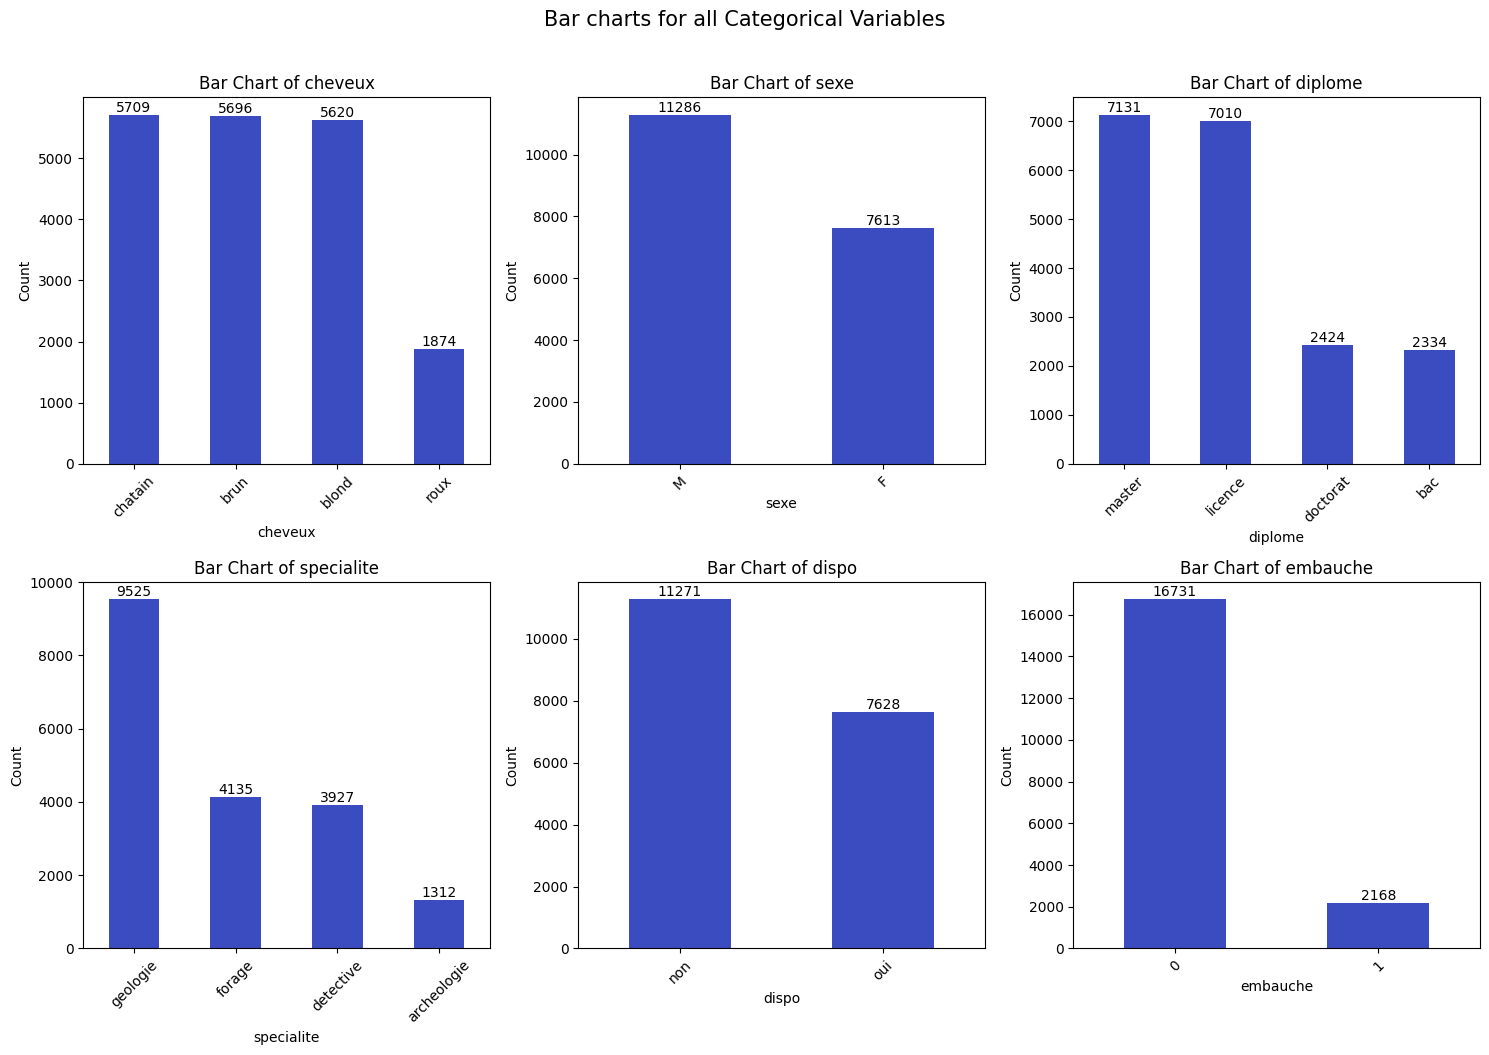

In [177]:
# Plotting bar charts for categorical data

df_cat = df.select_dtypes(include=['category'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, column in enumerate(df_cat):
    h = i // 3
    v = i % 3
    ax = axes[h, v]

    count = df_cat[column].value_counts()
    count.plot(kind="bar", ax=ax, colormap="coolwarm", rot=45)
    ax.set_title(f"Bar Chart of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Count")

    for j, count in enumerate(count):
        ax.annotate(count, xy=(j, count), ha="center", va="bottom")

fig.tight_layout()
plt.suptitle(
    "Bar charts for all Categorical Variables",
    fontsize=15,
    y=1.05,
)
plt.show()

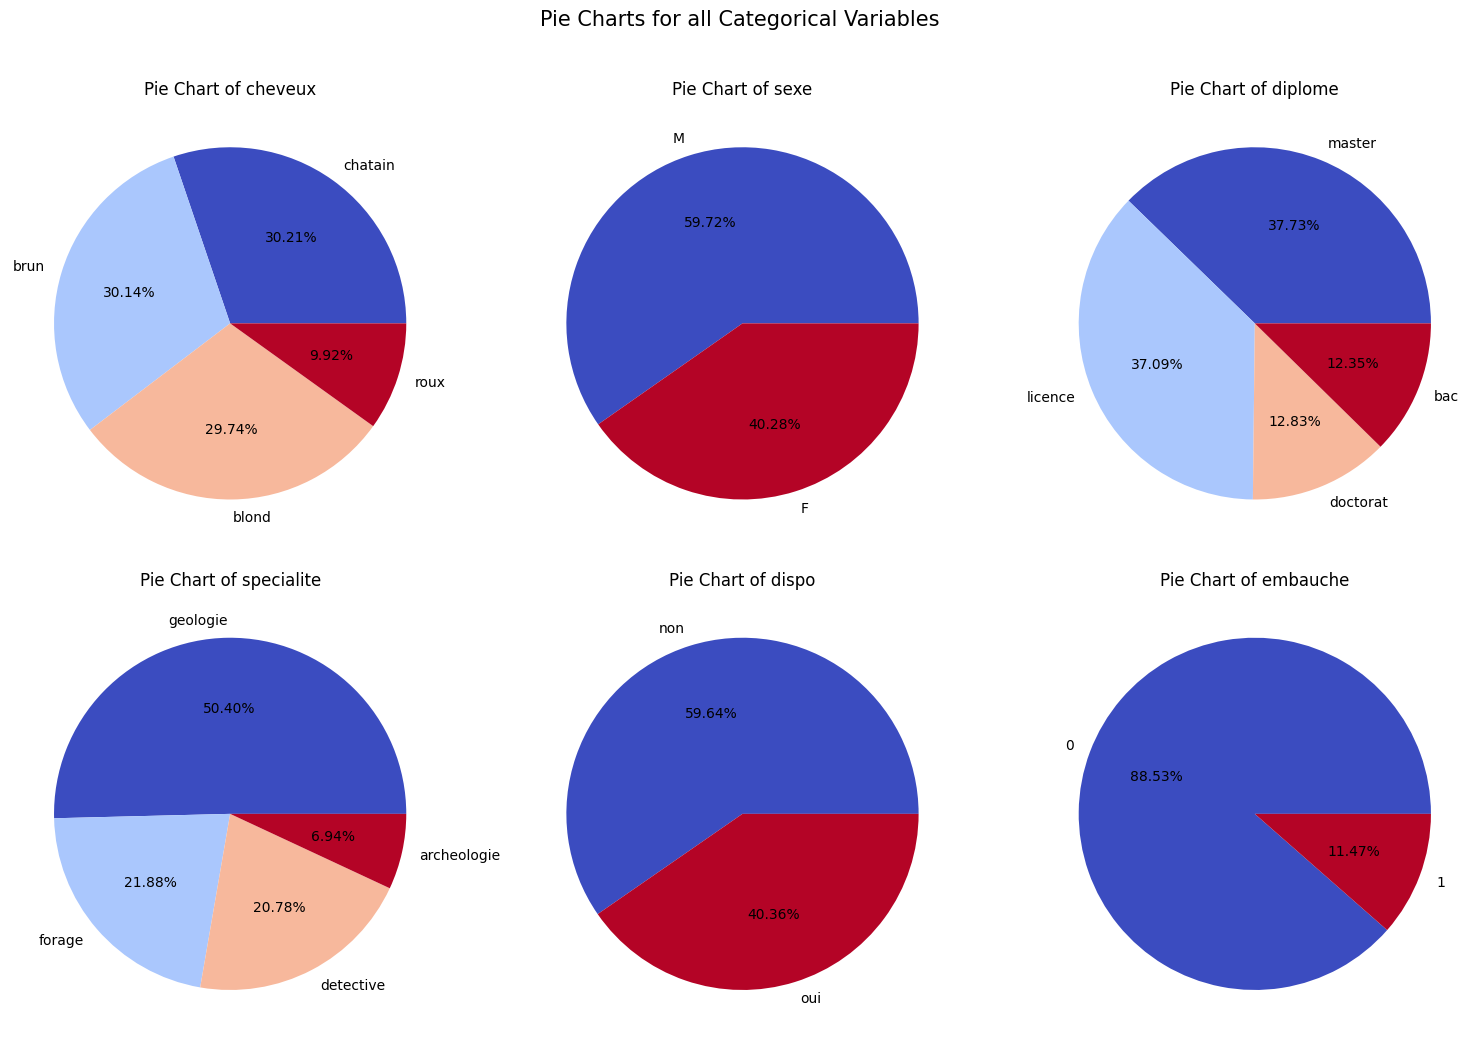

In [178]:
# Plotting pie charts for categorical data

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, column in enumerate(df_cat):
    h = i // 3
    v = i % 3
    ax = axes[h, v]

    df[column].value_counts().plot(
        kind="pie", ax=ax, autopct="%.2f%%", colormap="coolwarm"
    )
    ax.set_title(f"Pie Chart of {column}")
    ax.set_ylabel(None)

fig.tight_layout()
plt.suptitle(
    "Pie Charts for all Categorical Variables",
    fontsize=15,
    y=1.05,
)

plt.show()

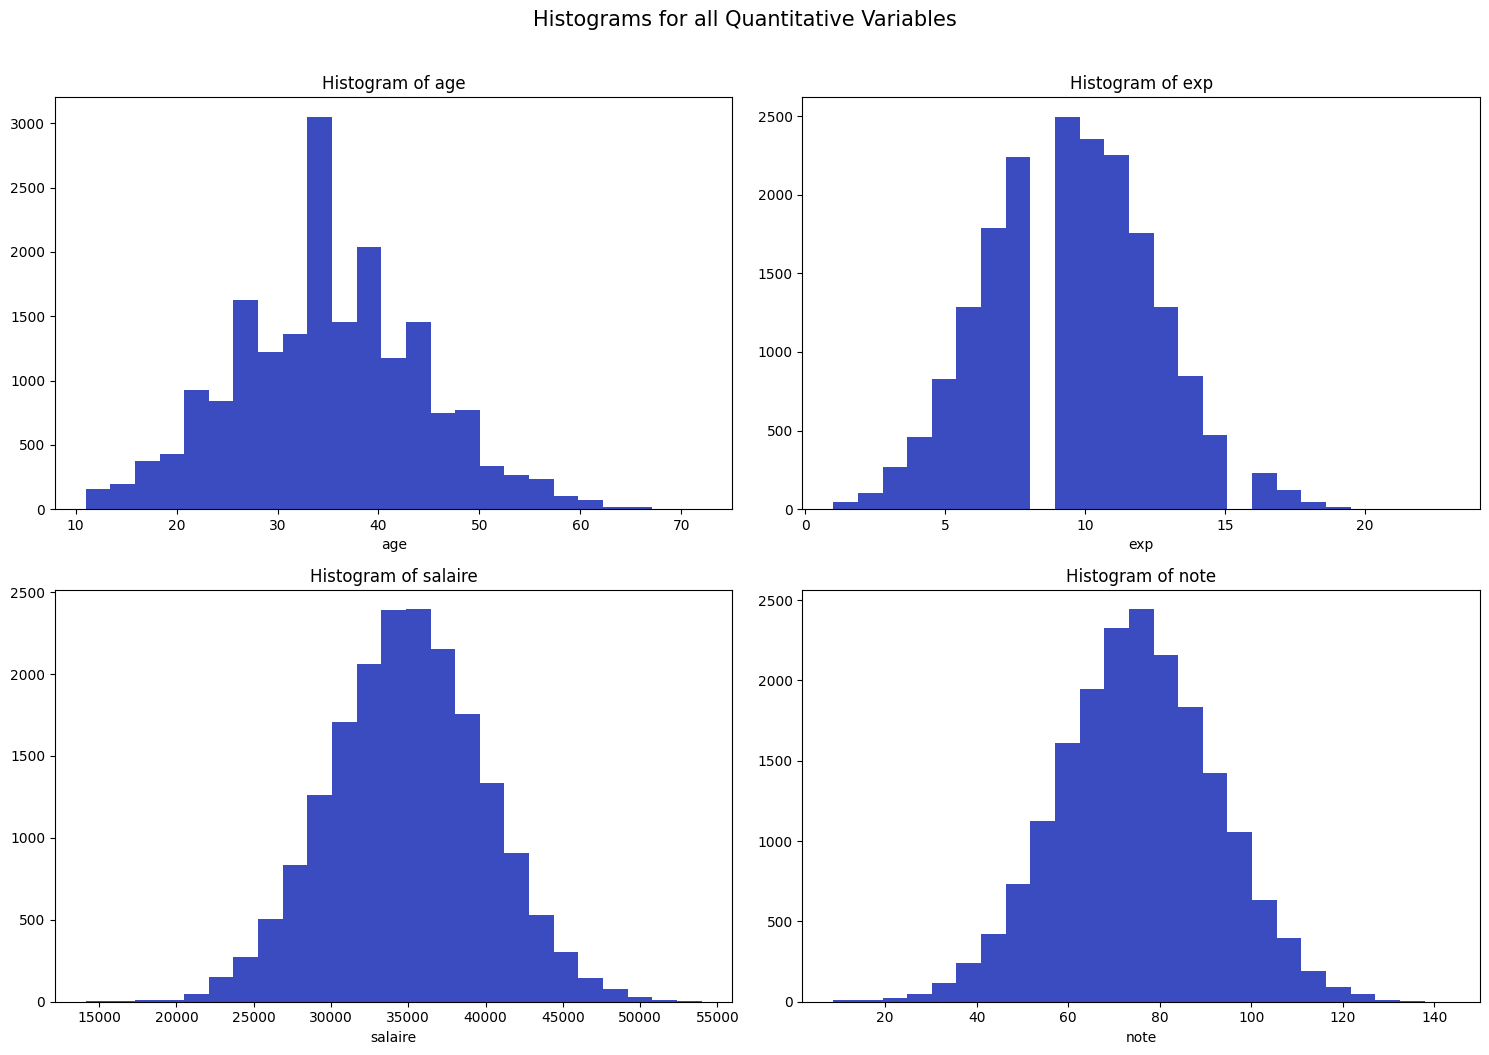

In [179]:
# Plotting histograms for quantitative variables

df_quant = df.select_dtypes(exclude=['category']).drop(columns = ['date'])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, column in enumerate(df_quant):
    h = i // 2
    v = i % 2
    ax = axes[h, v]

    df[column].plot(kind="hist", bins=25, ax=ax, colormap="coolwarm")

    ax.set_title(f"Histogram of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel(None)

fig.tight_layout()
plt.suptitle(
    "Histograms for all Quantitative Variables",
    fontsize=15,
    y=1.05,
)

plt.show()

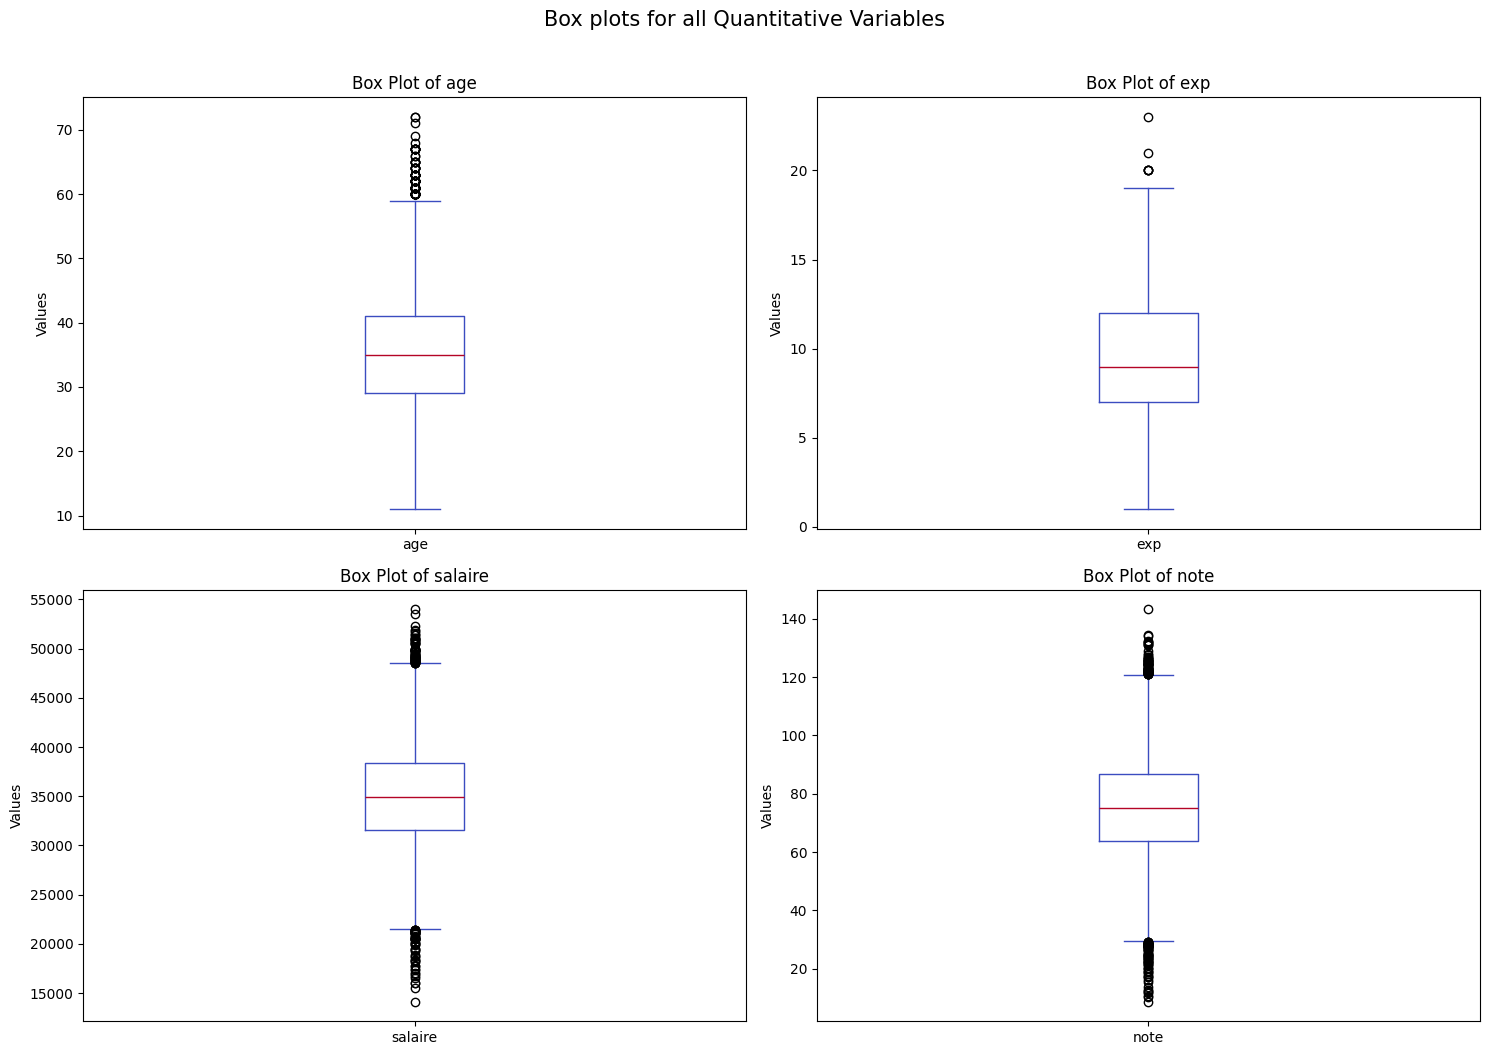

In [180]:
# Plotting box plots for quantitative variables

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, column in enumerate(df_quant):
    h = i // 2
    v = i % 2
    ax = axes[h, v]

    df_quant[column].plot(kind="box", ax=ax, colormap="coolwarm")
    ax.set_title(f"Box Plot of {column}")
    ax.set_ylabel("Values")

fig.tight_layout()
plt.suptitle(
    "Box plots for all Quantitative Variables",
    fontsize=15,
    y=1.05,
)
plt.show()

### Bi Variate Analysis

#### Cat Cat

In [181]:
def bi_cat_analysis(col1, col2):

    """defining a function to perform bivariate analysis on categorical variables and print the contingency table
    side-by-side and stacked bar charts"""

    contingency_table = (
        pd.crosstab(index=df[col1], columns=df[col2], normalize=True) * 100
    )
    print(contingency_table)

    observed_table = pd.crosstab(index=df[col1], columns=df[col2]).values

    chi_square, p, ddof, expected_table = stats.chi2_contingency(observed_table)

    cramers_v = math.sqrt(chi_square / len(df) * (min(observed_table.shape) - 1))

    if p < 0.05:
        print(
            f"**{col1}** and **{col2}** are not independent. The cramers v value is {cramers_v}."
        )
        if cramers_v <= 0.2:
            print(
                "The result is weak. Although the result is statistically significant, the variables are only weakly associated.\n"
            )
        elif cramers_v > 0.2 and cramers_v <= 0.6:
            print("The result is moderate. The variables are moderately associated.\n")
        elif cramers_v > 0.6:
            print("The result is strong. The variables are strongly associated.\n")
    else:
        print(f"**{col1}** and **{col2}** are independent.\n")

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    contingency_table.plot(kind="bar", ax=ax[0], stacked=False, cmap="coolwarm")
    ax[0].set_xlabel(col1)
    ax[0].set_ylabel(col2)
    ax[0].set_title("Side-by-Side Bar Chart")
    contingency_table.plot(kind="bar", ax=ax[1], stacked=True, cmap="coolwarm")
    ax[1].set_xlabel(col1)
    ax[1].set_ylabel(col2)
    ax[1].set_title("Stacked Bar Chart")
    plt.show()

embauche          0         1
cheveux                      
blond     26.218318  3.518705
brun      26.641621  3.497540
chatain   26.890312  3.317636
roux       8.778242  1.137626
**cheveux** and **embauche** are independent.



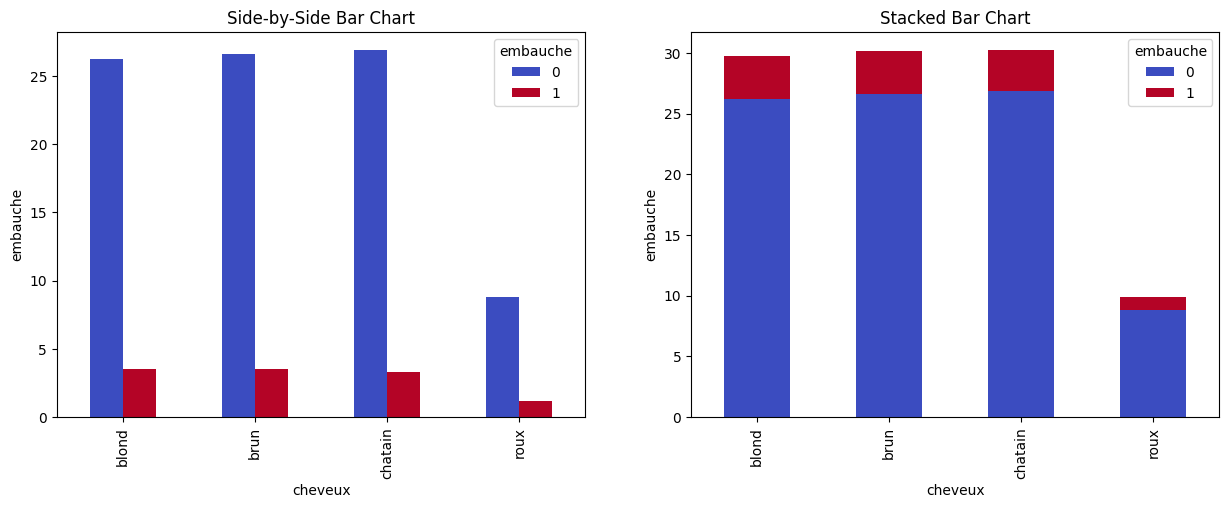

embauche          0         1
sexe                         
F         36.128896  4.153659
M         52.399598  7.317848
**sexe** and **embauche** are not independent. The cramers v value is 0.029731877589853885.
The result is weak. Although the result is statistically significant, the variables are only weakly associated.



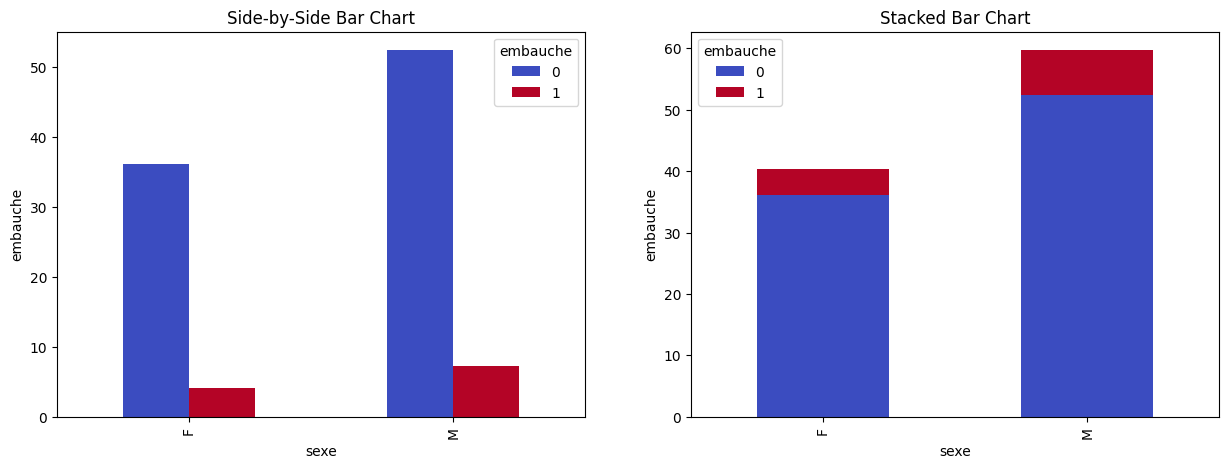

embauche          0         1
diplome                      
bac       11.302185  1.047674
doctorat  11.693740  1.132335
licence   32.583735  4.508175
master    32.948833  4.783322
**diplome** and **embauche** are not independent. The cramers v value is 0.05175257553184174.
The result is weak. Although the result is statistically significant, the variables are only weakly associated.



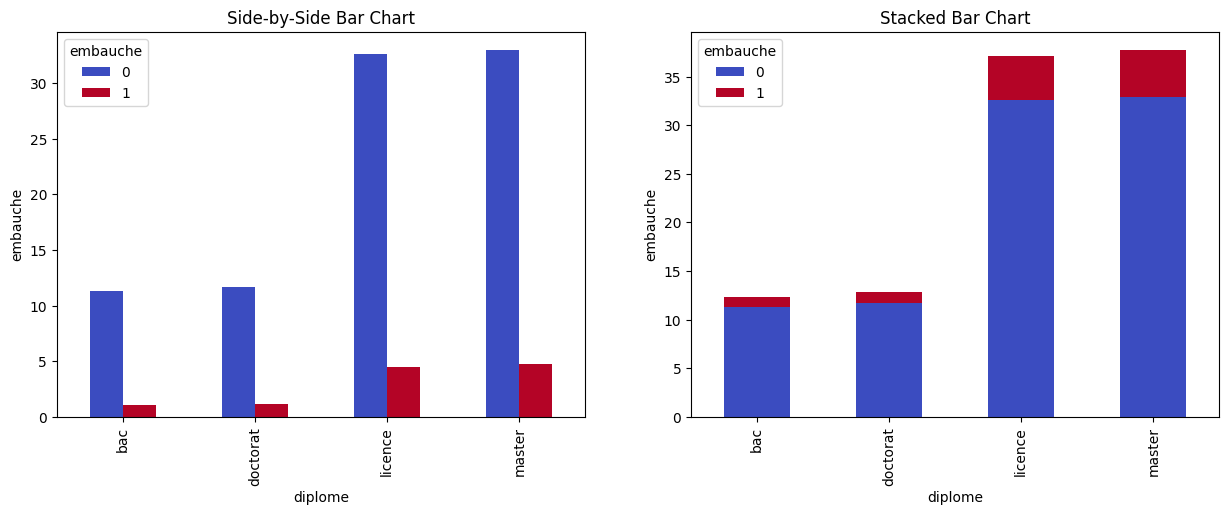

embauche             0         1
specialite                      
archeologie   5.529393  1.412773
detective    18.678237  2.100640
forage       19.858194  2.021271
geologie     44.462670  5.936822
**specialite** and **embauche** are not independent. The cramers v value is 0.08300878130098013.
The result is weak. Although the result is statistically significant, the variables are only weakly associated.



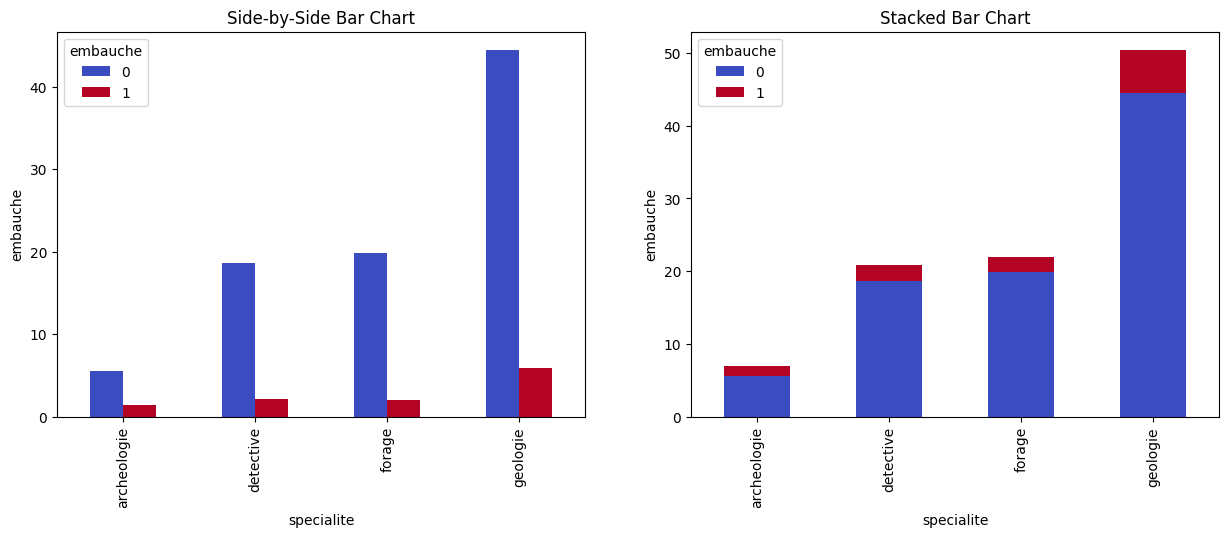

embauche          0         1
dispo                        
non       52.949892  6.688185
oui       35.578602  4.783322
**dispo** and **embauche** are independent.



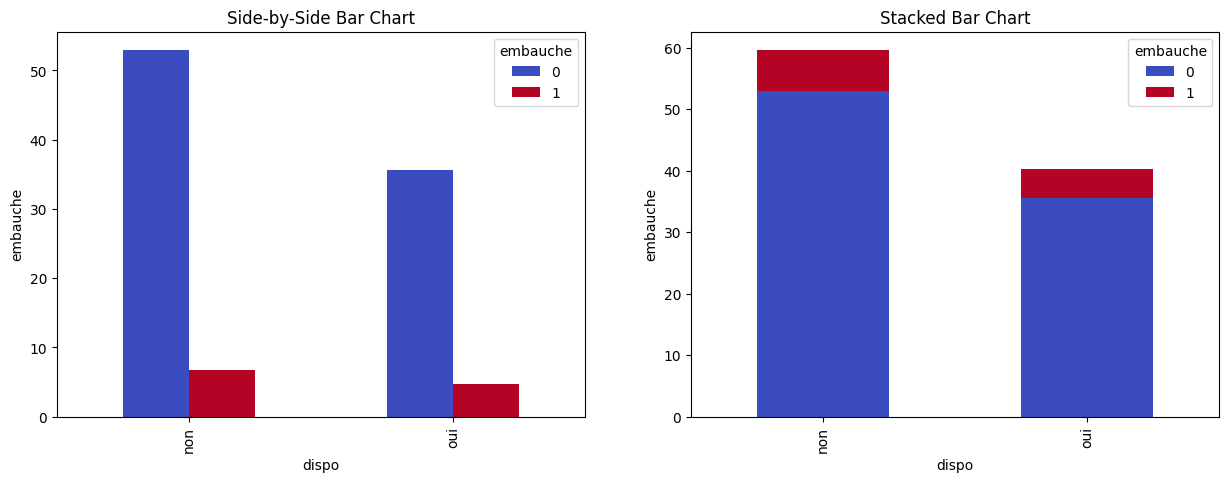

In [182]:
for i in range(len(df_cat.drop(columns = ['embauche']).columns)):
    col1 = df_cat.columns[i]
    col2 = 'embauche'
    bi_cat_analysis(col1, col2)

#### Num Num

Text(0.5, 1.0, 'Correlation Heatmap for quantitative variables')

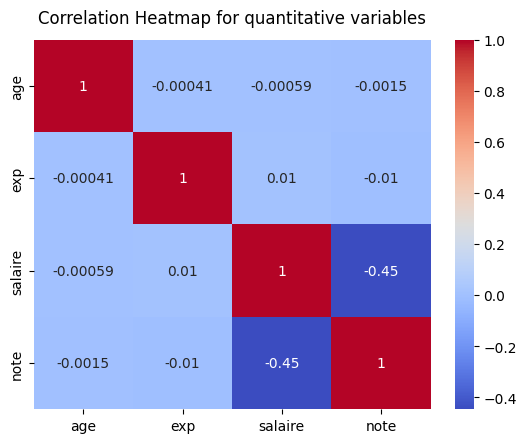

In [183]:
ax = sns.heatmap((df_quant).corr(), annot=True, cmap="coolwarm")
ax.set_title(
    "Correlation Heatmap for quantitative variables", fontdict={"fontsize": 12}, pad=12
)

#### Cat Num

In [184]:
# Running anova test on embauche with all quantitative variables

f_values = []
labels = []
for i in df_quant.columns:
    j = 'embauche'
    df_anova = df[[i, j]]
    grps = df[j].unique()
    d_data = {grp: df_anova.loc[df_anova[j] == grp, i] for grp in grps}
    F, p = stats.f_oneway(*[d_data[grp] for grp in grps])
    if p < 0.05:
        comb = f"For quant {i}, and categorical {j}"
        f_values.append(F)
        labels.append(comb)
        print(f"For quantitative {i}, and categorical {j} F ={F: .3f}, p ={p: .3f}")


For quantitative age, and categorical embauche F = 3.898, p = 0.048


C:\Users\namra\AppData\Local\Temp\ipykernel_19016\3397361449.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='embauche', y='age', data=df, ax=ax, palette="coolwarm")


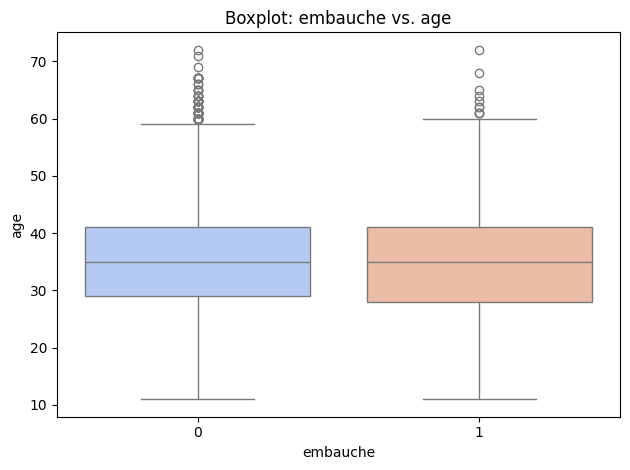

In [185]:
fig, ax = plt.subplots()

sns.boxplot(x='embauche', y='age', data=df, ax=ax, palette="coolwarm")
ax.set_xlabel('embauche')
ax.set_ylabel('age')
ax.set_title(f"Boxplot: embauche vs. age")

plt.tight_layout()
plt.show()


C:\Users\namra\AppData\Local\Temp\ipykernel_19016\2919544412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hired_df['year'] = hired_df['date'].dt.year


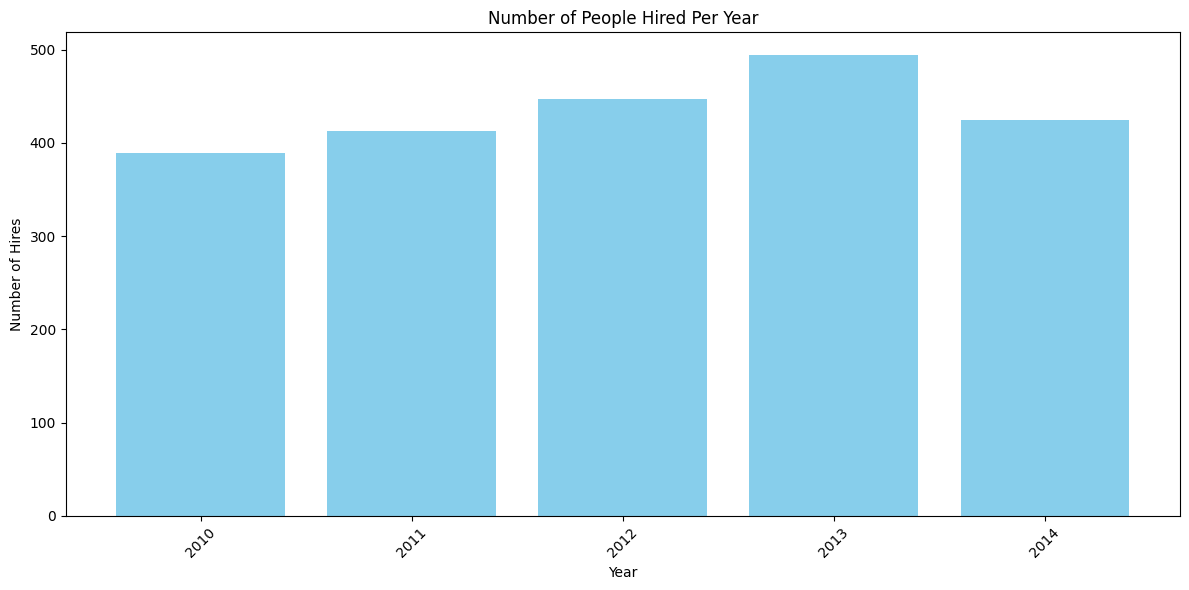

In [186]:
hired_df = df[df['embauche'] == 1]

hired_df['year'] = hired_df['date'].dt.year

hires_per_year = hired_df.groupby('year').size().reset_index(name='num_hires')

plt.figure(figsize=(12, 6))
plt.bar(hires_per_year['year'], hires_per_year['num_hires'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Hires')
plt.title('Number of People Hired Per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

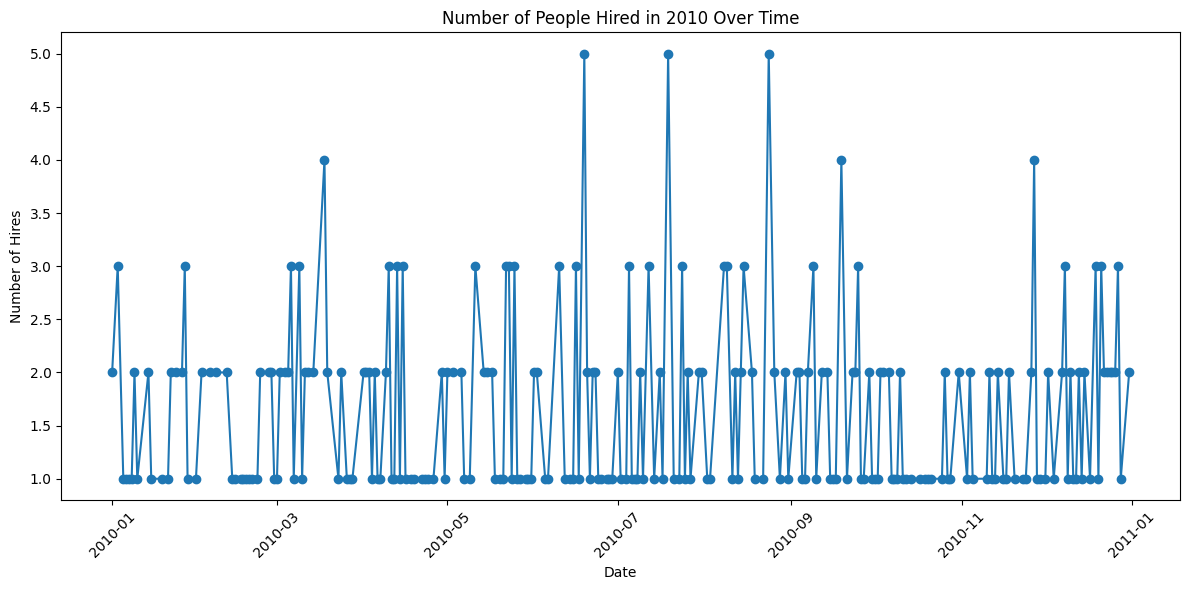

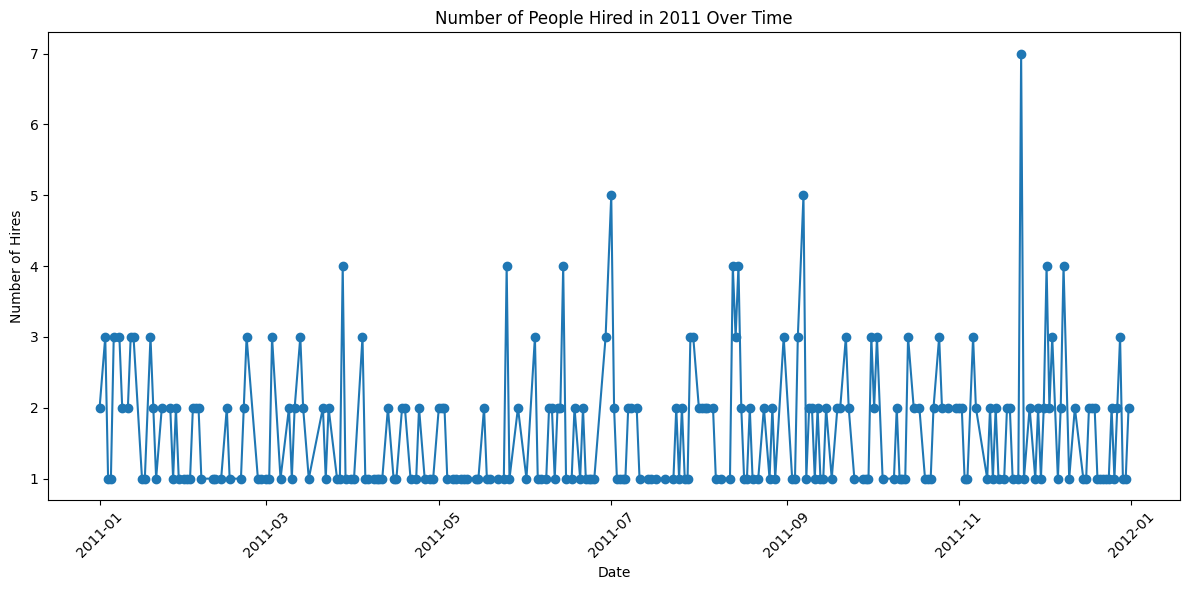

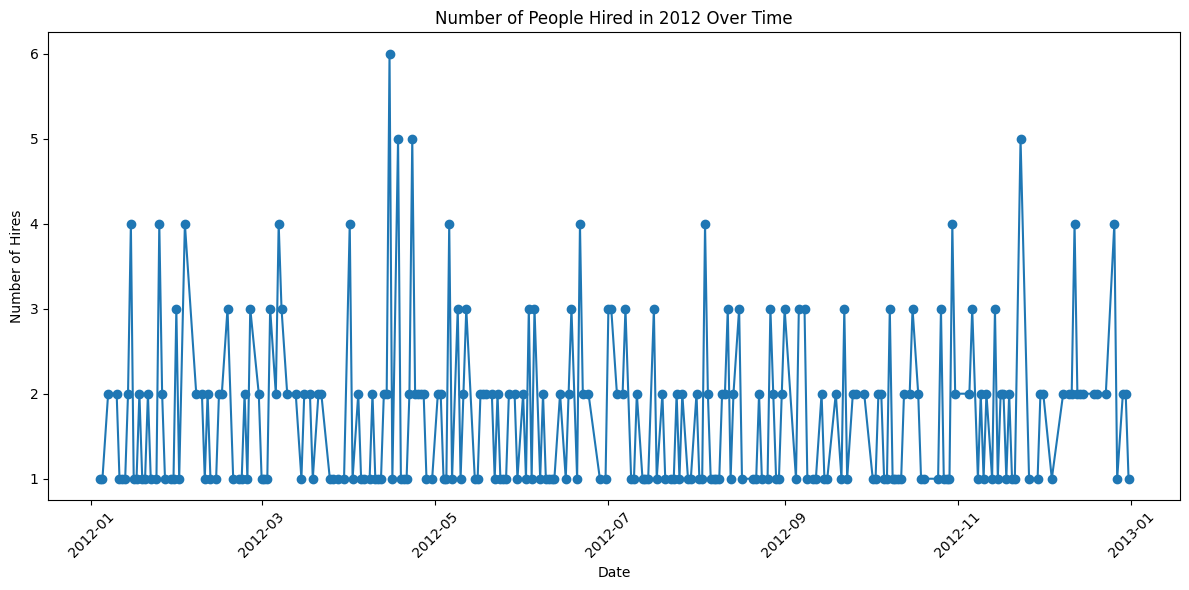

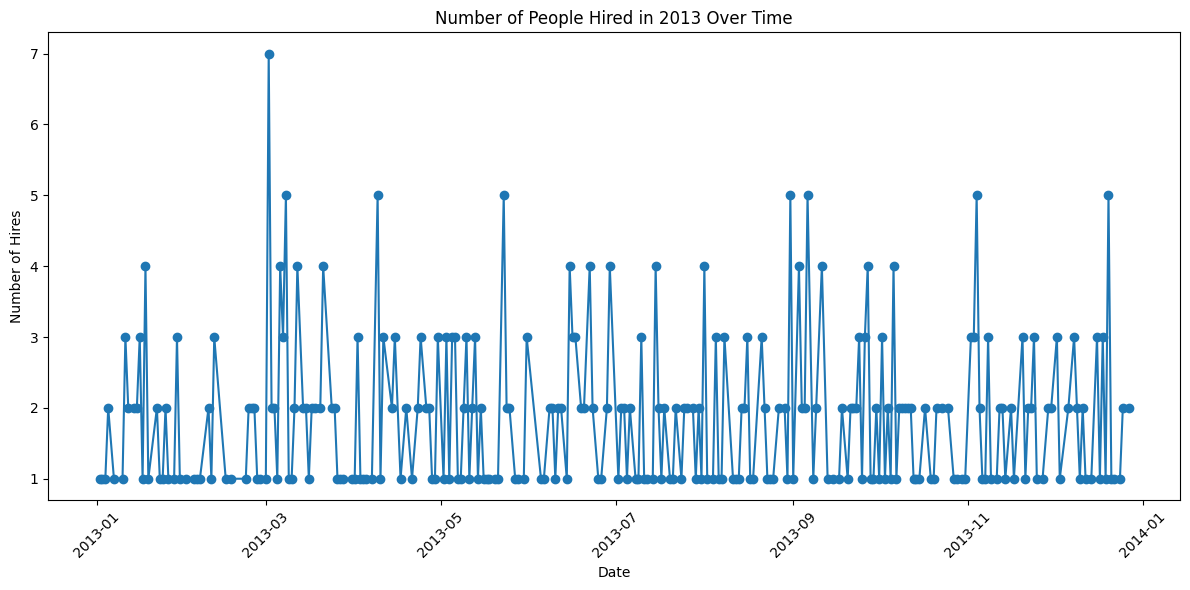

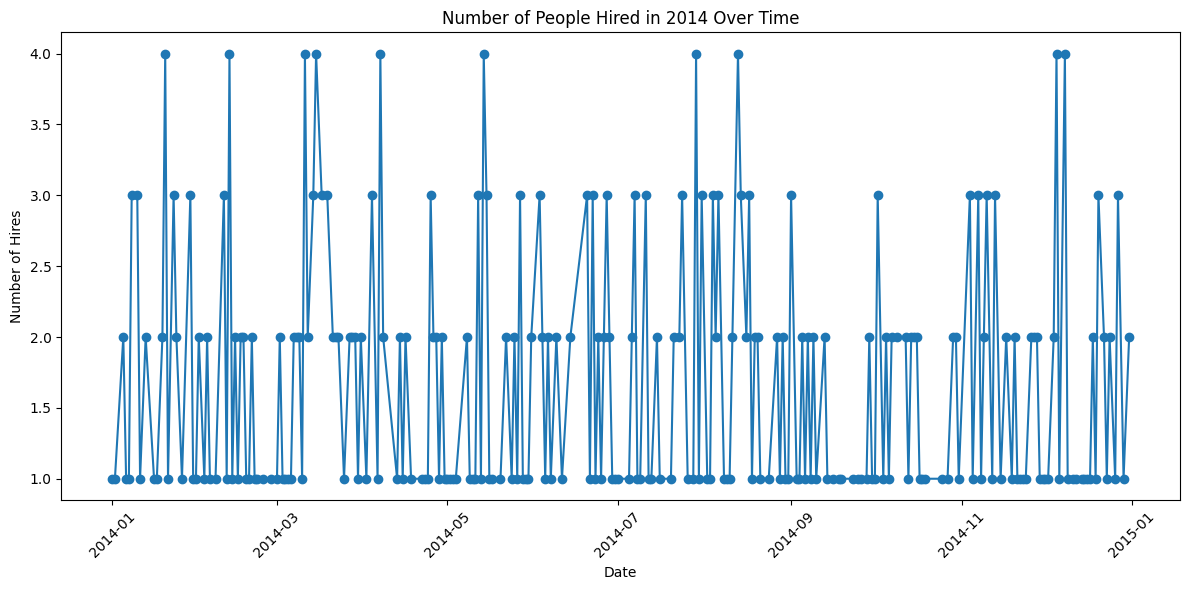

In [187]:
for year in df['date'].dt.year.unique():
    temp_df = df[df['date'].dt.year == year]
    hired_df = temp_df[temp_df['embauche'] == 1]
    hires_per_day = hired_df.groupby('date').size().reset_index(name='num_hires')
    plt.figure(figsize=(12, 6))
    plt.plot(hires_per_day['date'], hires_per_day['num_hires'], marker='o', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Number of Hires')
    plt.title(f'Number of People Hired in {year} Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [188]:
df['year'] = df['date'].dt.year

grouped_df = df.groupby(['specialite', 'year', 'embauche']).size().unstack(fill_value=0).reset_index()

grouped_df['percentage_hired'] = (grouped_df[1] / (grouped_df[0] + grouped_df[1])) * 100

print(grouped_df[['specialite', 'year', 'percentage_hired']])

embauche   specialite  year  percentage_hired
0         archeologie  2010         12.820513
1         archeologie  2011         21.317829
2         archeologie  2012         23.103448
3         archeologie  2013         24.626866
4         archeologie  2014         19.730942
5           detective  2010         11.096939
6           detective  2011          8.701299
7           detective  2012          9.743590
8           detective  2013          9.950249
9           detective  2014         11.026616
10             forage  2010          7.947805
11             forage  2011          9.057971
12             forage  2012          9.887359
13             forage  2013         10.229885
14             forage  2014          9.056604
15           geologie  2010         10.240655
16           geologie  2011         11.796832
17           geologie  2012         12.064343
18           geologie  2013         13.405797
19           geologie  2014         11.419753


C:\Users\namra\AppData\Local\Temp\ipykernel_19016\1691731700.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['specialite', 'year', 'embauche']).size().unstack(fill_value=0).reset_index()


In [189]:
df = copy.deepcopy(df_backup)

## Data Preprocessing

In [190]:
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):
    if isinstance(fldnames,str):
            fldnames = [fldnames]
    for fldname in fldnames:
            fld = df[fldname] # fld = df['saledate']
            fld_dtype = fld.dtype
            if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
                fld_dtype = np.datetime64

            if not np.issubdtype(fld_dtype, np.datetime64):
                df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
            targ_pre = re.sub('[Dd]ate$', '', fldname)
            attr = ['year', 'month', 'week', 'day', 
                    # 'dayofweek', 'dayofyear'
                    ]
            if time: 
                attr = attr + ['Hour', 'Minute', 'Second']
            for n in attr: 
                if hasattr(fld.dt, n.lower()):
                    df[targ_pre + n] = getattr(fld.dt, n.lower())
            df[targ_pre + 'is_weekend'] = (fld.dt.dayofweek // 5).astype(int)
            if drop: df.drop(fldname, axis=1, inplace=True)
    
    return df

In [191]:
# OHE for all categorical

def dummy_encode(df):
    object_columns = df.select_dtypes(include=['category']).columns
    df = pd.get_dummies(df, columns=object_columns)
    return df

In [192]:
def scaling(df):
    columns_to_scale = df_quant.columns
    rob_scaler = RobustScaler()
    for column in columns_to_scale:
        df[f'scaled_{column}'] = rob_scaler.fit_transform(df[column].values.reshape(-1, 1))
    df.drop(columns=columns_to_scale, axis=1, inplace=True)
    return df

In [193]:
X = df.drop('embauche', axis=1)  
y = df['embauche']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15119, 10)
X_test shape: (3780, 10)
y_train shape: (15119,)
y_test shape: (3780,)


In [194]:
X_train = scaling(X_train)
X_train = add_datepart(X_train, 'date')
X_train = dummy_encode(X_train)

In [195]:
X_train.columns

Index(['scaled_age', 'scaled_exp', 'scaled_salaire', 'scaled_note', 'year',
       'month', 'day', 'is_weekend', 'cheveux_blond', 'cheveux_brun',
       'cheveux_chatain', 'cheveux_roux', 'sexe_F', 'sexe_M', 'diplome_bac',
       'diplome_doctorat', 'diplome_licence', 'diplome_master',
       'specialite_archeologie', 'specialite_detective', 'specialite_forage',
       'specialite_geologie', 'dispo_non', 'dispo_oui'],
      dtype='object')

In [197]:
X_test.columns

Index(['scaled_age', 'scaled_exp', 'scaled_salaire', 'scaled_note', 'year',
       'month', 'day', 'is_weekend', 'cheveux_blond', 'cheveux_brun',
       'cheveux_chatain', 'cheveux_roux', 'sexe_F', 'sexe_M', 'diplome_bac',
       'diplome_doctorat', 'diplome_licence', 'diplome_master',
       'specialite_archeologie', 'specialite_detective', 'specialite_forage',
       'specialite_geologie', 'dispo_non', 'dispo_oui'],
      dtype='object')

In [198]:
chevuex_cols = ['cheveux_blond',
       'cheveux_brun', 'cheveux_chatain', 'cheveux_roux']

## Modelling

### Logistic Regression

In [199]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=7)
params = {
    'penalty':['l1', 'l2'],
    'C': np.arange(1,100)
}
search = RandomizedSearchCV(model, scoring='recall', cv=10,
                            n_iter=10, param_distributions=params,
                            refit=True, n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_

In [200]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.5415224913494809
              precision    recall  f1-score   support

           0       0.91      0.58      0.70     13385
           1       0.14      0.54      0.23      1734

    accuracy                           0.57     15119
   macro avg       0.52      0.56      0.47     15119
weighted avg       0.82      0.57      0.65     15119



In [201]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.5368663594470046
              precision    recall  f1-score   support

           0       0.91      0.59      0.72      3346
           1       0.15      0.54      0.23       434

    accuracy                           0.58      3780
   macro avg       0.53      0.56      0.47      3780
weighted avg       0.82      0.58      0.66      3780



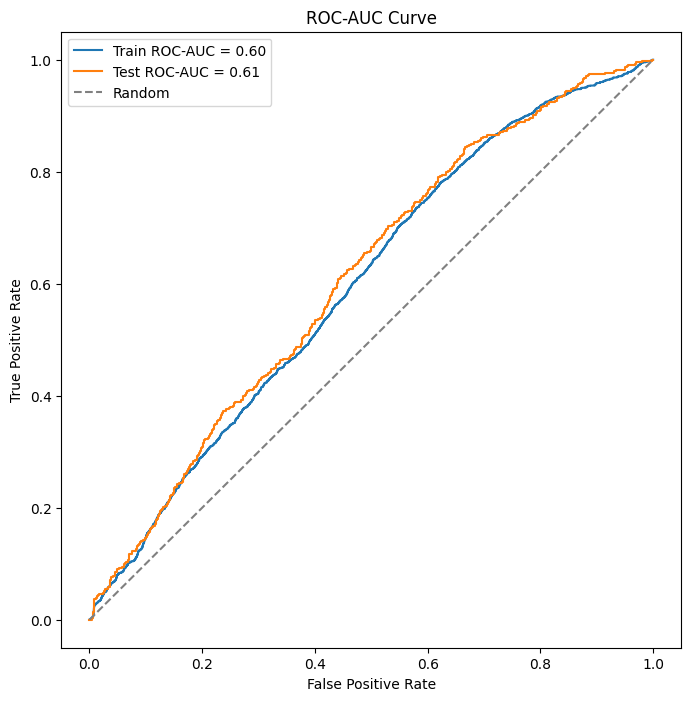

In [202]:
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train_proba)
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

# Compute ROC curve and ROC-AUC for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train ROC-AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

### Bagging: Random Forest

In [203]:
rnd_clf = RandomForestClassifier(
    n_estimators = 20,
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 3,
    min_samples_split = 2,
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_features = 'sqrt',
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0,
    random_state = 42,
    bootstrap = True,
    oob_score = True,
    max_samples = None,
    warm_start = False,
    n_jobs = -1,
    verbose = 0,
)

rnd_clf.fit(X_train, y_train)
best_model = rnd_clf

C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [204]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.0
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     13385
           1       0.00      0.00      0.00      1734

    accuracy                           0.89     15119
   macro avg       0.44      0.50      0.47     15119
weighted avg       0.78      0.89      0.83     15119



C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [205]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.0
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3346
           1       0.00      0.00      0.00       434

    accuracy                           0.89      3780
   macro avg       0.44      0.50      0.47      3780
weighted avg       0.78      0.89      0.83      3780



C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

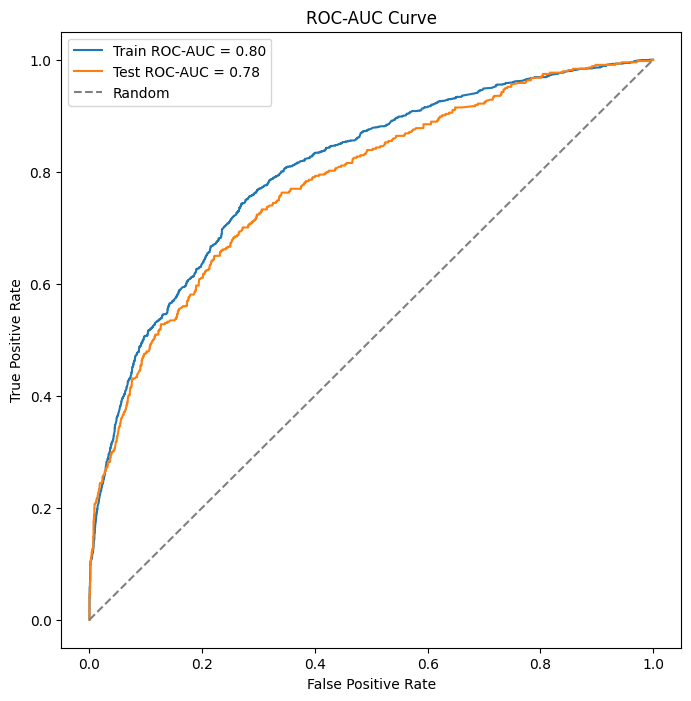

In [206]:
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train_proba)
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

# Compute ROC curve and ROC-AUC for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train ROC-AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

In [207]:
rnd_clf = RandomForestClassifier(
    n_estimators = 20,
    class_weight = 'balanced', # updated the class_weight parameter
    criterion = 'gini', 
    max_depth = 3,
    min_samples_split = 2,
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_features = 0.75,
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0,
    random_state = 42,
    bootstrap = True,
    oob_score = True,
    max_samples = None,
    warm_start = False,
    n_jobs = -1,
    verbose = 0,
)

rnd_clf.fit(X_train, y_train)
best_model = rnd_clf

C:\Users\namra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [208]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.6937716262975778
              precision    recall  f1-score   support

           0       0.94      0.60      0.73     13385
           1       0.18      0.69      0.29      1734

    accuracy                           0.61     15119
   macro avg       0.56      0.65      0.51     15119
weighted avg       0.85      0.61      0.68     15119



In [209]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Performance on the test set
Test recall: 0.6589861751152074
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      3346
           1       0.18      0.66      0.28       434

    accuracy                           0.61      3780
   macro avg       0.55      0.63      0.51      3780
weighted avg       0.85      0.61      0.68      3780



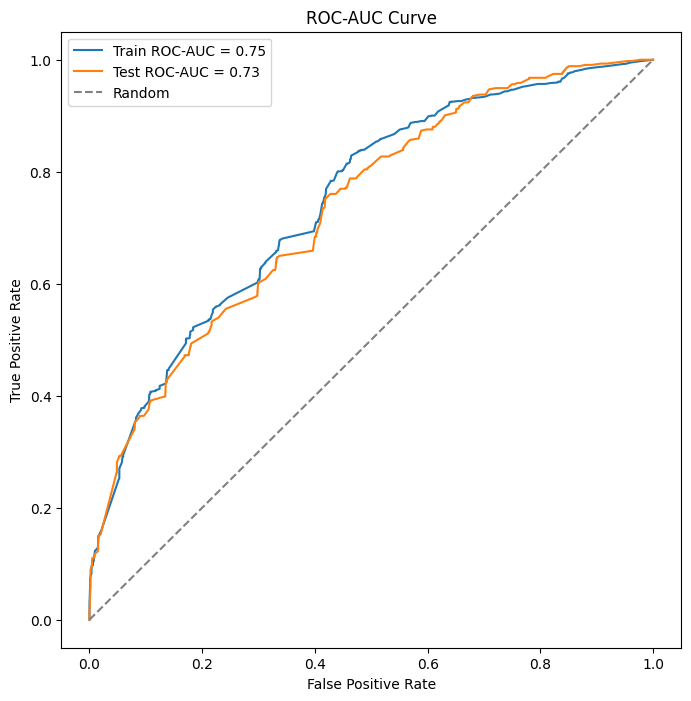

In [210]:
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train_proba)
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

# Compute ROC curve and ROC-AUC for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train ROC-AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

In [211]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  For a comparison between tree-based ensemble models see the example
 |  :ref:`sp

### Boosting: LightGBM

In [212]:
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                       n_estimators = 300,
                       colsample_bytree = .7,
                       min_child_samples=10,
                       subsample=.7,
                       objective='binary',
                       random_state=7, n_jobs=-1,
                       importance_type='split')

%timeit model.fit(X_train, y_train)
best_model = model #search.best_estimator_

[LightGBM] [Info] Number of positive: 1734, number of negative: 13385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 15119, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1734, number of negative: 13385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 15119, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Nu

In [213]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.9930795847750865
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     13385
           1       0.70      0.99      0.82      1734

    accuracy                           0.95     15119
   macro avg       0.85      0.97      0.89     15119
weighted avg       0.96      0.95      0.95     15119



In [214]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.6866359447004609
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3346
           1       0.50      0.69      0.58       434

    accuracy                           0.89      3780
   macro avg       0.73      0.80      0.76      3780
weighted avg       0.90      0.89      0.89      3780



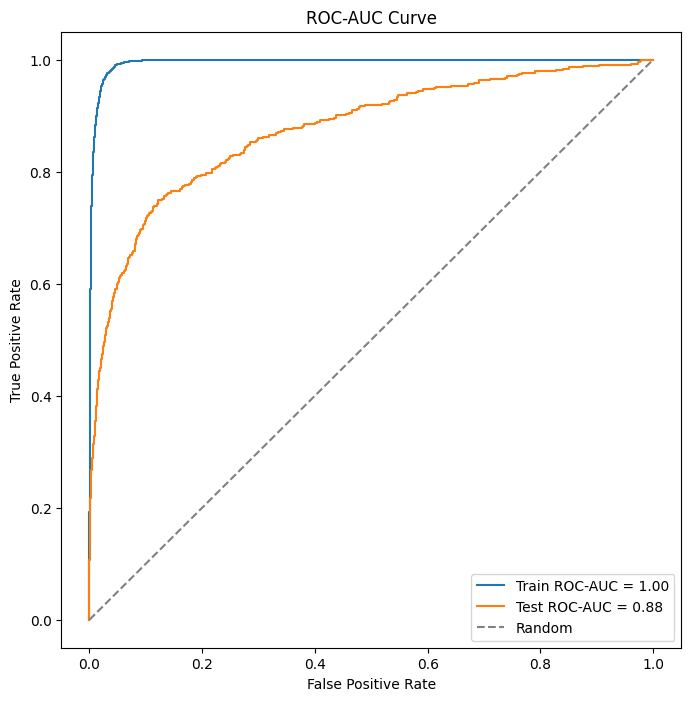

In [215]:
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train_proba)
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

# Compute ROC curve and ROC-AUC for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train ROC-AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


Cross Validation and HyperParameter Tuning

In [216]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomS

In [217]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_samples': [5, 10, 15],
    'subsample': [0.6, 0.7, 0.8],
    'learning_rate': [0.005, 0.01, 0.1]
}

model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                           objective='binary', random_state=7, n_jobs=-1,
                           importance_type='split')

kf = KFold(n_splits=5, shuffle=True, random_state=7) 

grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=kf, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 1383, number of negative: 10712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 12095, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1411, number of negative: 10684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 12095, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightG

In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.9140715109573241
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     13385
           1       0.50      0.91      0.64      1734

    accuracy                           0.88     15119
   macro avg       0.74      0.90      0.79     15119
weighted avg       0.93      0.88      0.90     15119



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.7419354838709677
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3346
           1       0.41      0.74      0.53       434

    accuracy                           0.85      3780
   macro avg       0.69      0.80      0.72      3780
weighted avg       0.90      0.85      0.87      3780



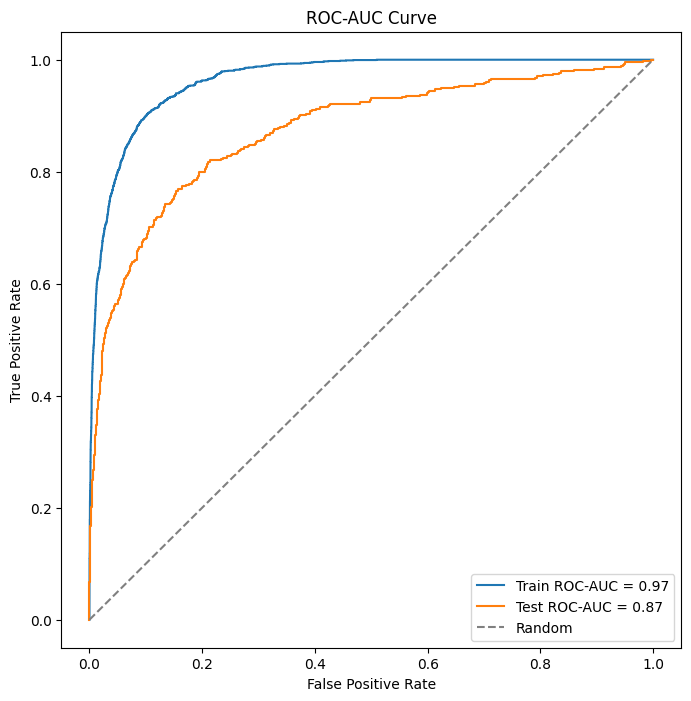

In [ ]:
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train_proba)
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

# Compute ROC curve and ROC-AUC for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train ROC-AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


Dropping the chevuex columns as they may be impacting the model performance since chevuex and embauche columns are independent. 

In [ ]:
X_train = X_train.drop(columns = chevuex_cols)
X_test = X_test.drop(columns = chevuex_cols)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_samples': [5, 10, 15],
    'subsample': [0.6, 0.7, 0.8],
    'learning_rate': [0.005, 0.01, 0.1]
}

model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                           objective='binary', random_state=7, n_jobs=-1,
                           importance_type='split')

kf = KFold(n_splits=5, shuffle=True, random_state=7) 

grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=kf, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 1383, number of negative: 10712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 12095, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1411, number of negative: 10684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 12095, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightG

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
               learning_rate=0.01, min_child_samples=15, n_estimators=300,
               n_jobs=-1, objective='binary', random_state=7, subsample=0.6)

In [ ]:
print('Performance on the train set')
y_pred_train = best_model.predict(X_train)
print('Train recall:', recall_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Performance on the train set
Train recall: 0.8241061130334487
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     13385
           1       0.36      0.82      0.50      1734

    accuracy                           0.81     15119
   macro avg       0.67      0.82      0.69     15119
weighted avg       0.90      0.81      0.84     15119



In [ ]:
print('Performance on the test set')
y_pred = best_model.predict(X_test)
print('Test recall:', recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Performance on the test set
Test recall: 0.7488479262672811
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      3346
           1       0.33      0.75      0.46       434

    accuracy                           0.79      3780
   macro avg       0.64      0.77      0.66      3780
weighted avg       0.89      0.79      0.83      3780



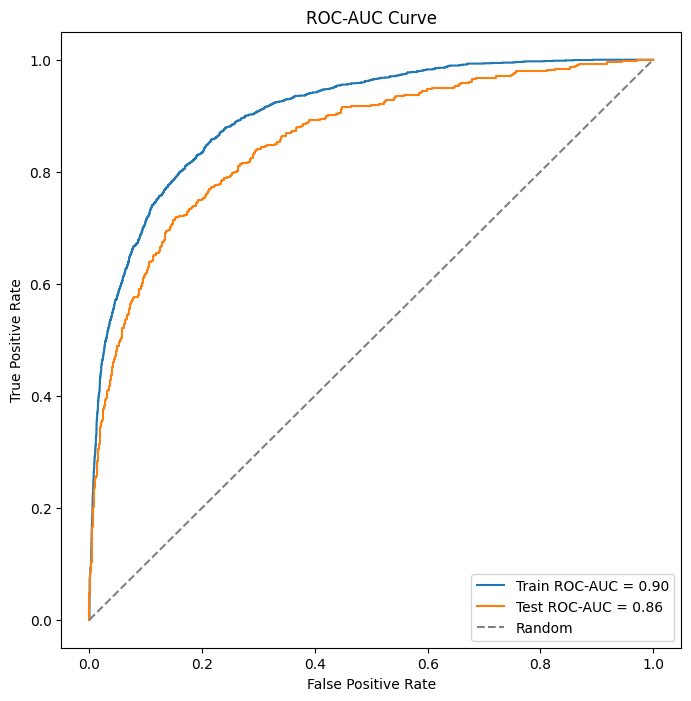

In [ ]:
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train_proba)
roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

# Compute ROC curve and ROC-AUC for validation set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Train ROC-AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC-AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()
